# Clustering players using psychological traits

## Dataset

The provided file `clustering_data.csv` contains **survey responses from a psychological assessment** for players of a mobile game. 

The dataframe format is as follows:
- Each **row** is a response from **one individual player**.
- Each **column** is a **specific psychological variable** (see Column Glossary below for more information). You can assume that 
    - the first part of the column name (the **letter**) denotes a **variable category**, e.g. all columns starting with the same letter are somehow related.
    - the second part (the **number**) is just a counter for variables within a category, e.g. `B_3` is the `4th` variable within category `B` (0-based index)

## Goal

Use this data to build a model that can cluster these players based on their ***psychological similarity*** (a concept that you should define here how you see fit).

## Procedure

Please do some data exploration and try to address the following questions:
- is there any caution needed with any of the data format (type)?
- what about the high dimensionality of columns?
- statistically speaking, is there enough data for the task at hand?
- which clustering algorithm would you pick?
- how to evaluate the goodness of the clustering? which metrics would you use?
- how to determine the optimal number of clusters? (consider both data science and customer usability angles here)

*(Note: these are just suggestions and not an exhaustive list - feel free to raise any other points you think are relevant!)*

## Coding Guidelines

Please use Python to complete this challenge and make sure that your results can be easily executed from this notebook. You can either include all your code in this notebook or extract some of the functionality into separate Python modules. You will also be evaluated on code style, efficiency and cleanliness. Feel free to use third party libraries like `numpy`, `scipy` or `sklearn`.

## Column Glossary

|Letter| Comment|
|--|--|
|A| all Likert scale (1-7)|
|B| all related to one ranking question|
|C| all Likert scale (1-7)|
|D| 0-36 binary from one multiple choice question, 37-55 linear combinations of binaries|
|E| all Likert scale (1-7)|
|F| all binary from one multiple choice question|
|G| all Likert scale (1-7)|
|H| all Likert scale (1-7)|
|I| all Likert scale (1-7)|
|J| all Likert scale (1-7)|
|K| 0-65 binary from one multiple choice question, 66-72 linear combinations of binaries|
|L| 0-47 binary from one multiple choice question, 48-60 linear combinations of binaries|
|M| 0-31 binary from one multiple choice question, 32-37 linear combinations of binaries|
|N| all binary from one multiple choice question|
|O| all Likert scale (1-7)|
|P| all Likert scale (1-7)|

# Your work goes here

## Summary Of Implementation:

- All the data pre-processing logic is kept inside `pre_processing.py` file which contains a `PreProcessing` class.
    - From initial data exploration I found that there are no NaN values present in the data. Threrfore, PreProcessing class has an assertion or assumption that loaded data will always have None `NaN` values. If `ǸaN` values are expected then modification in PreProcessing class will be necessary.
    - As part of pre-processing data has been scaled using MinMaxScaler per feature.
    - Also, if a feature are co-related and having correlation threshold is more than 0.85 that feature will be discarded from the data. (This can also be modified via one attribute of the PreProcessing class).
    - Lastly, as part of the feature selection `PCA` is also applied as part of the PreProcessing. Instead of only taking few components/features by number I am here considering preserving the variance which can result in more number of features present even after PCA. However, via doing this we are keeping vital information in the data.
- All the model related logic like training, prediction are kept inside `model.py` file which contains a `Model` class.
    - As we are dealing with an Unsupervised Learning problem as an initial implementation I have used `KMeans` algorithm. And in order to find the optimum amount of clusters present in our dataset I have considered two methods 1. Kmeans Squared Error and 2. Silhouette Score.
    - Kmeans Squared Error gives us how far the clusters are from their respective centroid and trying this for several number of clusters and plotting the graph using `Elbow method` we can intuitively conclude the number of clusters. On top of that from Silhouette score we can validate this intuition as Silhouette scores gives information how distinct our data-points will be from other clusters. Combining these two information number of cluster taken from our dataset is `2`.

### Result
- Dataset is divided into two parts train and test. Via performing above mentioned analysis we concluded that there two clusters present in our dataset. Hence, we are training the Kmeans model with the argument of `n_cluster=2` on train data. And validating results on test data.
- Results from test data shows there are almost same number of data falls into the cluster 1 and cluster 2.
- Since, its an unsupervised learning model is used we really dont have any direct information regarding the actual label or output and hence can not calculate F1 Score.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import altair as alt

from pre_processing import PreProcessing
from model import Model

pd.set_option('display.max_columns', None)
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [2]:
kmeans_kwargs = {
    'init': 'k-means++',
    'random_state': 44,
}
iterations = 11
fig_size = (10, 8)

preprocessed_df = PreProcessing(filepath='clustering_data.csv')()
model = Model()
sse, silhouette_coefficients = model.get_kmeans_silhouette_scores(iterations=iterations, data=preprocessed_df.values,
                                                                  **kmeans_kwargs)

/home/vedantparikh/solsten/.venv/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Applied MinMaxScaler to the DataFrame.
Dropping similar columns if the similarity threshold is greater or equal to `0.85`.
 Resulting DataFrame shape is: `(3270, 329)`.
Applied PCA to each feature and merged all resulting DataFrame. 
 Resulting PCA DataFrame shape is `(3270, 177)`.
Finished preprocessing of data.


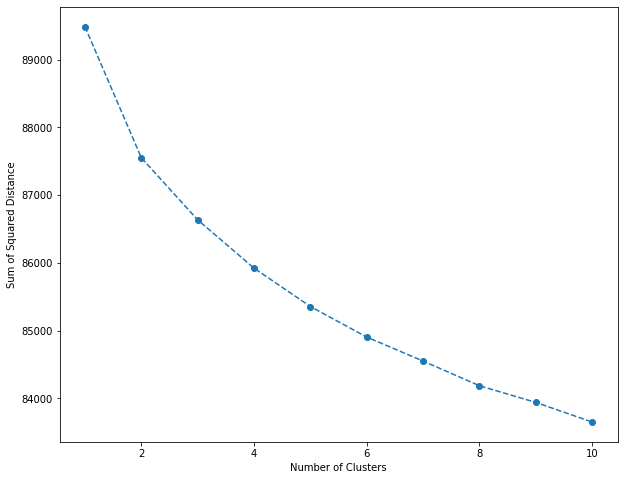

In [3]:
plt.figure(figsize=fig_size)
plt.plot(range(1, iterations), sse, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distance")
plt.show()

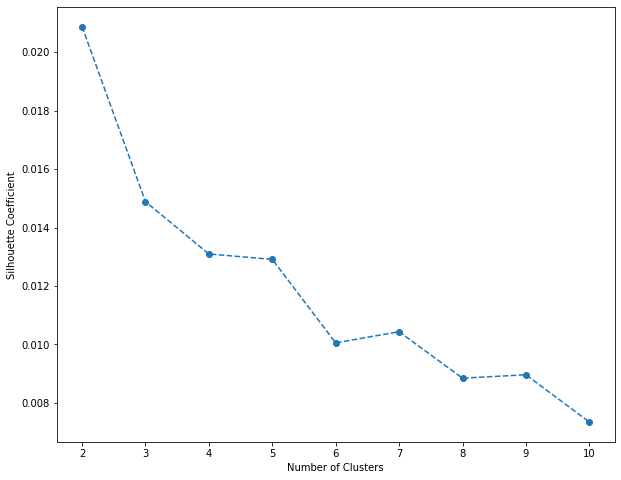

In [4]:
plt.figure(figsize=fig_size)
plt.plot(range(2, iterations), silhouette_coefficients, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Splitting Data

In [5]:
train_data, test_data = train_test_split(preprocessed_df, test_size=0.2, random_state=44)

### Making Prediction

Here, from above KMeans plot and Silhouette plot we are concluding that optimum number of clusters present in our data is `2`

In [6]:
kmeans_pca = model.train(data=train_data.values, n_clusters=2, **kmeans_kwargs)
predictions = model.predict(data=test_data.values, kmeans_pca=kmeans_pca)

pred_column_names = [f'pca_{i}' for i in range(test_data.values.shape[1])]
pred_df = pd.DataFrame()
pred_df[pred_column_names] = test_data.values
pred_df['cluster'] = predictions
pred_df.head()

/home/vedantparikh/solsten/.venv/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/vedantparikh/solsten/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100,pca_101,pca_102,pca_103,pca_104,pca_105,pca_106,pca_107,pca_108,pca_109,pca_110,pca_111,pca_112,pca_113,pca_114,pca_115,pca_116,pca_117,pca_118,pca_119,pca_120,pca_121,pca_122,pca_123,pca_124,pca_125,pca_126,pca_127,pca_128,pca_129,pca_130,pca_131,pca_132,pca_133,pca_134,pca_135,pca_136,pca_137,pca_138,pca_139,pca_140,pca_141,pca_142,pca_143,pca_144,pca_145,pca_146,pca_147,pca_148,pca_149,pca_150,pca_151,pca_152,pca_153,pca_154,pca_155,pca_156,pca_157,pca_158,pca_159,pca_160,pca_161,pca_162,pca_163,pca_164,pca_165,pca_166,pca_167,pca_168,pca_169,pca_170,pca_171,pca_172,pca_173,pca_174,pca_175,pca_176,cluster
0,0.913697,-0.796631,0.459329,-0.104144,-0.430486,-0.786112,-0.436701,0.353165,-0.826947,0.613815,0.595655,0.549320,0.112312,-0.177133,-0.214607,-0.132160,-1.254856,-0.930916,0.076772,0.681350,0.529457,-0.858464,-0.527106,0.628643,0.058816,-0.035541,0.661250,-1.062958,0.238238,-0.217914,0.515554,-1.354936,-0.825316,-0.126558,-0.730059,0.093638,0.990794,0.816928,-0.266119,-0.496818,0.056414,0.393182,0.132404,-0.038515,-0.095242,0.251756,-0.180875,0.002470,0.772798,-0.414923,0.447591,0.101377,0.854407,0.007759,-0.202121,0.274402,0.277665,0.128462,0.023962,-0.529083,-0.390800,-0.000309,-0.554779,0.332159,-0.041002,-0.571993,0.550755,-0.182929,0.335759,-0.110018,-0.185462,0.083263,-0.516415,0.307877,-0.528534,-0.045425,-0.288117,0.212864,-0.251239,-0.483561,0.633992,-0.410359,0.039973,-0.099790,0.008473,-0.341264,0.130221,0.334729,-0.146149,0.011548,-0.356799,0.134648,-0.520681,0.158463,-0.126078,0.511411,0.170325,0.225146,-0.541531,0.048796,0.131299,0.193268,0.342696,-0.272120,-0.155276,-0.558357,-0.237087,-0.137694,-0.160745,0.112426,0.287403,-0.031700,-0.050975,-0.246223,0.089624,-0.037689,-0.089931,-0.040324,0.265206,-0.014691,-0.555818,-0.303630,-0.241960,0.194885,-0.168708,-0.210021,-0.085561,0.054128,0.333939,0.098329,-0.042862,0.377681,-0.023187,0.112214,-0.070952,-0.204632,-0.363384,-0.576367,0.123071,-0.079377,0.132378,0.009878,0.158566,-0.034296,-0.027802,-0.115111,0.124773,-0.122017,-0.040017,0.141937,-0.029708,0.031946,-0.047662,-0.321425,0.186620,-0.027661,-0.065676,0.210261,-0.206544,0.150549,0.141248,0.337478,-0.150673,-0.028671,-0.225344,0.208817,0.135924,-0.272181,-0.105091,0.173870,0.005914,-0.141707,0.380904,0.237880,-0.227025,-0.171798,0.191417,0
1,1.887164,-0.466033,0.273212,-0.288495,1.196095,0.337796,0.393468,0.476399,-0.278876,-0.087264,0.001542,-0.668050,0.262213,1.146381,0.319525,0.177083,-0.595818,0.226794,0.342951,-0.379568,-0.540690,-0.542448,0.068335,-0.351323,-0.043070,-0.427283,-0.354705,-0.737722,0.101121,-0.452418,-0.379573,0.027717,0.543615,-0.260494,0.309735,0.086539,-0.126243,0.279298,0.027511,0.567162,0.257182,0.016632,-0.261621,-0.733067,-0.083452,-1.058604,0.446971,0.270467,0.253737,0.136517,-0.539066,-0.379538,0.062071,-0.455310,-0.490236,0.581407,0.401506,-0.145430,0.681467,-0.333883,-0.757470,-0.698063,-0.084013,-0.341555,-0.238158,0.478005,0.507170,0.193503,0.317533,-0.437193,-1.035816,-0.067761,0.433651,0.331820,-0.694103,0.177125,0.111087,-0.429525,0.114923,-0.385724,-0.031936,0.269524,0.177524,-0.544810,0.535554,0.316684,0.021646,-0.063390,-0.051289,0.289590,0.239750,-0.505598,-0.126682,0.251323,-0.280152,-0.171603,0.621332,-0.002992,0.386429,0.159215,-0.326868,0.011924,0.859766,-0.381649,-0.12

### Plotting results

In [7]:
scatter_plot = alt.Chart(pred_df).mark_circle(size=60).encode(
    x='pca_0',
    y='pca_1',
    color='cluster:N',
    tooltip=['pca_0', 'pca_1', 'cluster']
).interactive()

histogram_plot = alt.Chart(pred_df).mark_bar().encode(
    alt.X("cluster:Q"),
    y='count()',
    color='cluster:N',
    tooltip=['count()']
)
scatter_plot | histogram_plot

alt.HConcatChart(...)